In [1]:
from collections import defaultdict
from functools import reduce
from itertools import chain, cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import smartsheet

from portfolio import CashFlow, debug_row, PortfolioSheetRow
from utils import colorscale, SmartsheetRow

# Portfolio Cash Flow Analysis

In [2]:
# Define a quartely time schema
years_in_model = 3
quarters = list(range(1, years_in_model * 4 + 1))  # list bc we don't want this to be a generator
quarters_index = list(range(years_in_model * 4))
quarter_labels = ['Q' + str(q) for q in quarters]

# smartsheet
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

# debug_row(38, sheet)

In [3]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 20
SHEET_ROW_END = 70

def sheet_row_to_cf(row):
    return CashFlow(
        delay_qtrs = row.delay_qtrs,
        discounted = True,
        discount_rate = row.discount_rate,
        max_amt = row.max_amt,
        scale_up_qtrs = row.scale_up_qtrs,
        function = row.function,
        name = row.name,
        is_cost = row.is_cost,
        start_amt=row.start_value,
    )

# iterate through smartsheet and build project map
project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue

    row = PortfolioSheetRow(sheet_row.to_dict())
    if row.project_code and row.include_in_model:
        project_map[row.project_code].append(sheet_row_to_cf(row))

# Build DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        rows.append([project_id, True, cash_flow.name] + cash_flow.discounted_qtr)  # Discounted
        rows.append([project_id, False, cash_flow.name] + cash_flow.non_discounted_qtr)  # Undiscounted
        
df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
df.groupby(['project', 'discounted']).sum(numeric_only=True).sum(numeric_only=True, axis=1).reset_index(name='NPV')

,project,discounted,NPV
0,BP,False,12.980000
1,BP,True,12.912016
2,FS,False,27.412765
3,FS,True,21.287263
4,PV,False,22.225145
5,PV,True,13.297180


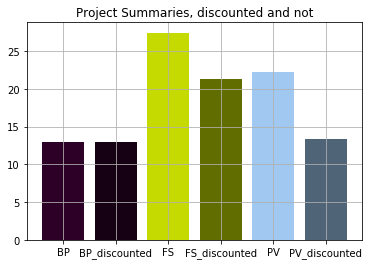

In [4]:
def gen_label(row):
    postfix = '_discounted' if row['discounted'] else ''
    return row['project'] + postfix

table = df.groupby(['project', 'discounted'])\
          .sum(numeric_only=True)\
          .sum(numeric_only=True, axis=1)\
          .reset_index(name='NPV')

table['label'] = table.apply(gen_label, axis=1)
table


# This is way overly complex, but was fun to write
colors = ["#2D0028", "#C5DA00", "#A0C8F0", "#9BA08C"]
colors_cycled = list(islice(
    cycle(colors),     # generator of infinitely repeated colors
    0,                 # start at the beginning
    len(project_map)), # we're going to zip later & 2x the proj num is # of bars
) 
darkened_colors = map(lambda color: colorscale(color, .5), colors_cycled)
bar_colors = list(chain.from_iterable(zip(colors_cycled, darkened_colors)))

# TODO: Add colors to bars based on project code beign in the x-axis label
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(table['label'], table['NPV'], color=bar_colors)
ax.set_title('Project Summaries, discounted and not')
ax.grid(True)

In [5]:
def display_dataframe(df, title):
    display(HTML(f'<div><h3>{title}</h3></div>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

    
for project_id in df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = df[df['project'] == project_id].set_index('name')
    display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,0.0,0.007622,0.015058,0.022313,0.029390,0.036296,0.043032,0.049605,0.056017,0.062272,0.068375,0.074330
Pipeline FS Product Credits,0.0,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Stockton,0.0,0.000000,0.000000,0.000000,0.302942,0.291766,0.281605,0.272368,0.263971,0.256338,0.249398,0.243089
Pipeline FS - Magic Valley,0.0,0.000000,0.316106,0.298353,0.282916,0.269492,0.257819,0.247669,0.238842,0.231167,0.224493,0.218690
Projected Whitespace Wins,0.0,0.000000,0.000000,0.629576,0.744355,0.938631,1.224998,1.566022,1.872924,2.072964,2.159398,2.166336
Projected Margin Accretion,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.068536,0.079641,0.098437,0.126143,0.159137,0.188830
Total,0.0,0.187622,0.511164,1.130241,1.539603,1.716184,2.055991,2.395305,2.710192,2.928885,3.040802,3.071275


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline FS Product Credits,0.0,0.18,0.18,0.18,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Stockton,0.0,0.00,0.00,0.00,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000
Pipeline FS - Magic Valley,0.0,0.00,0.36,0.36,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000
Projected Whitespace Wins,0.0,0.00,0.00,0.65,0.797015,1.059816,1.471566,2.000000,2.528434,2.940184,3.202985,3.350000
Projected Margin Accretion,0.0,0.00,0.00,0.00,0.000000,0.000000,0.072800,0.089266,0.118699,0.164815,0.224000,0.283185
Total,0.0,0.18,0.54,1.19,1.697015,1.959816,2.444366,2.989266,3.547133,4.004999,4.326985,4.533185


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,0.40,0.351220,0.304819,0.260710,0.218810,0.179036,0.141311,0.105557,0.071701,0.039672,0.009401,-0.019180
Internal Headcount,0.00,0.014468,0.028583,0.042354,0.055788,0.068896,0.081683,0.094159,0.106330,0.118204,0.129789,0.141091
Revenue Defense - Showme,0.40,0.392771,0.385803,0.379088,0.372615,0.366376,0.360362,0.354566,0.348979,0.343594,0.338404,0.333402
United Ethanol Whitespace Win,0.24,0.235663,0.231482,0.227453,0.223569,0.219825,0.216217,0.212739,0.209387,0.206157,0.203042,0.200041
Guardian - Hankinson Defense,0.00,0.000000,0.000000,0.000000,0.000000,0.347702,0.339013,0.330836,0.323140,0.315896,0.309079,0.302662
Valero - Net new,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233932
Madeira - Fleet Trials,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157948,0.154539,0.151331
Total,1.04,0.994121,0.950687,0.909604,0.870782,1.181834,1.138586,1.097857,1.059538,1.181472,1.144255,1.343280


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,0.40,0.35,0.30,0.25,0.20,0.15,0.10,0.05,5.551115e-17,-0.05,-0.10,-0.15
Internal Headcount,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00
Revenue Defense - Showme,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,4.000000e-01,0.40,0.40,0.40
United Ethanol Whitespace Win,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,2.400000e-01,0.24,0.24,0.24
Guardian - Hankinson Defense,0.00,0.00,0.00,0.00,0.00,0.40,0.40,0.40,4.000000e-01,0.40,0.40,0.40
Valero - Net new,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.40
Madeira - Fleet Trials,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.20,0.20,0.20
Total,1.04,0.99,0.94,0.89,0.84,1.19,1.14,1.09,1.040000e+00,1.19,1.14,1.49


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,0.00,0.010851,0.021437,0.031765,0.041841,0.051672,0.061262,0.070619,0.079747,0.088653,0.097342,0.105819
Benefits - Contracted GPRE,0.75,0.727941,0.707180,0.687640,0.669249,0.651941,0.635650,0.620318,0.605887,0.592306,0.579523,0.567492
Benefits - Potential GPRE,0.00,0.000000,0.000000,0.158025,0.222410,0.307521,0.414211,0.537858,0.665971,0.779489,0.859559,0.896002
Total,0.75,0.738792,0.728617,0.877430,0.933501,1.011133,1.111123,1.228795,1.351605,1.460447,1.536423,1.569313


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
Benefits - Contracted GPRE,0.75,0.75,0.75,0.750,0.750000,0.750000,0.750000,0.750000,0.750000,0.75,0.750000,0.750000
Benefits - Potential GPRE,0.00,0.00,0.00,0.225,0.356258,0.554162,0.839725,1.226692,1.708737,2.25,2.791263,3.273308
Total,0.75,0.75,0.75,0.975,1.106258,1.304162,1.589725,1.976692,2.458737,3.00,3.541263,4.023308


In [6]:
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
            
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]
        
        def get_max(flows):
            values = reduce(list.__add__, [list(map(lambda v: abs(v), flow.qtr)) for flow in flows])
            maximum = max(values)
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            rows = len(self.cash_flows) // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)  # or get_min_max
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                # TODO: should pull from "tot_qtrs" in some way
#                 linestyle_discounted = '-' if cf.discounted else '--'
#                 linestyle_non_discounted = '--' if cf.discounted else '-'
                ax.plot(range(12), cf.discounted_qtr, color='r', label='discounted')
                ax.plot(range(12), cf.non_discounted_qtr, label='non-discounted')
                ax.legend()
                
            plt.show(fig)

In [7]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id}</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))

In [8]:
graph_out = widgets.Output()

def combine_flows(flows, is_discounted):
    if is_discounted:
        qtr_values = map(lambda cf: cf.discounted_qtr, flows)
    else:
        qtr_values = map(lambda cf: cf.non_discounted_qtr, flows)
    aggregated_values = [sum(values) for values in zip(*qtr_values)]
    return aggregated_values

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary(is_discounted):
    projects_values = map(lambda p: combine_flows(p.cash_flows, is_discounted), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (25, 8)
    plt.figure(figsize=figsize)
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(xseries, combine_flows(project.cash_flows, is_discounted), width=bar_width)
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(net_xseries, projects_net, color='black', width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:
        display(HTML('<h2>Discounted</h2>'))
        plot_projects_summary(is_discounted=True)
        
        display(HTML('<h2>Undiscounted</h2>'))
        plot_projects_summary(is_discounted=False)

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [9]:
df.sort_values(by=['discounted', 'project'], inplace=True)

In [10]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [11]:
# This entire cell contains all of the code needed
# to build the excel sheet to be downloaded

def record_project(project, sheet, start_row, start_column=0):
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(project.to_df(), 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    for index, row in project.to_df().iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./demo.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

In [12]:
%%html
<style>
.dwnld {
    border: 1px solid black;
    border-radius: 4px;
    padding: 5px;
    text-decoration: none !important;
}
</style>
<a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>